<center>
    <font size="6"><b>Introduction to Time Series Prediction</b></font>
    <br>
    <font size="3">(draft version)</font>
</center>

<br>

<center>
    <font size="3"><b>Piotr Lipiński</b></font>
    <br>
    Computational Intelligence Research Group, Institute of Computer Science, University of Wroclaw, Poland
    <br>
    lipinski@cs.uni.wroc.pl
</center>

### Abstract:

This notebook presents an introduction to time series prediction and illustrates the problem on the Airline Passengers dataset.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

%matplotlib inline

## 1. Time Series Data

In [15]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])
df

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

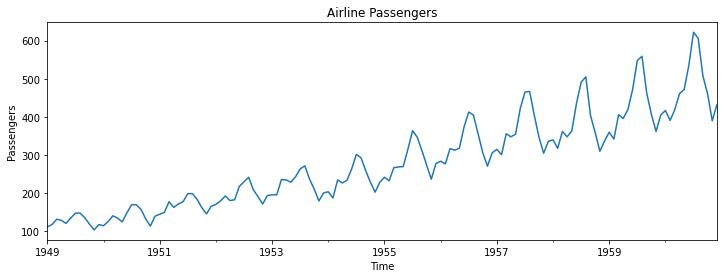

In [16]:
plt.figure(figsize=(12,4))
df['Passengers'].plot()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.show()

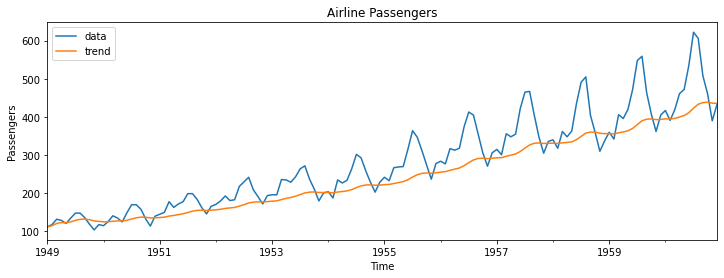

In [17]:
# df['trend'] = df['Passengers'].rolling(window=12, min_periods=1).mean()
# df['trend'] = df['Passengers'].ewm(span=12).mean()
df['trend'] = df['Passengers'].ewm(halflife=12).mean()

plt.figure(figsize=(12,4))
df['Passengers'].plot(label='data')
df['trend'].plot(label='trend')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

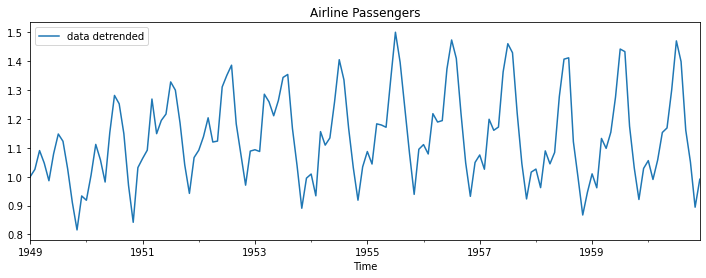

In [18]:
# df['detrended'] = df['Passengers'] - df['trend']
df['detrended'] = df['Passengers'] / df['trend']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

Month
1     1.045050
2     1.028700
3     1.166366
4     1.130612
5     1.131236
6     1.267675
7     1.384267
8     1.352408
9     1.167931
10    1.026496
11    0.904672
12    1.022858
Name: seasonality, dtype: float64

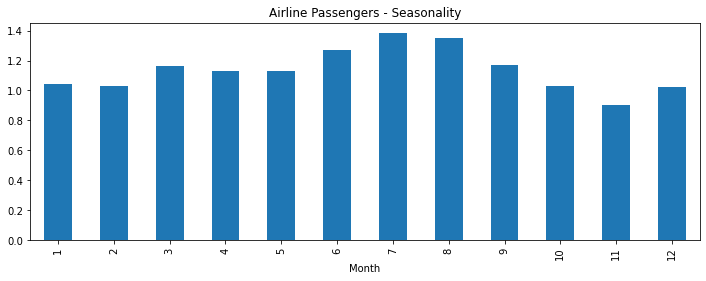

In [19]:
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
display(df_seasonality)

plt.figure(figsize=(12,4))
df_seasonality.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('')
plt.title('Airline Passengers - Seasonality')
plt.show()

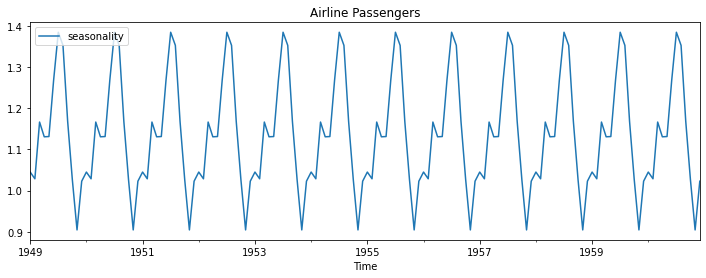

In [20]:
df = df.join(df_seasonality, how='left', on=df.index.month)

plt.figure(figsize=(12,4))
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

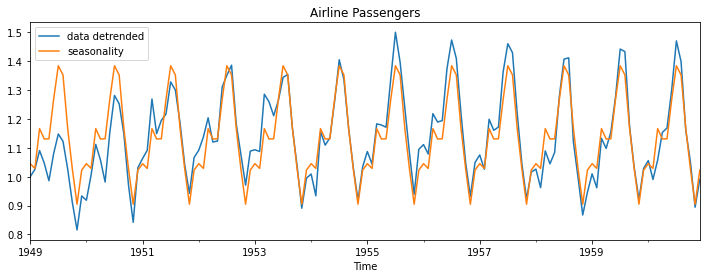

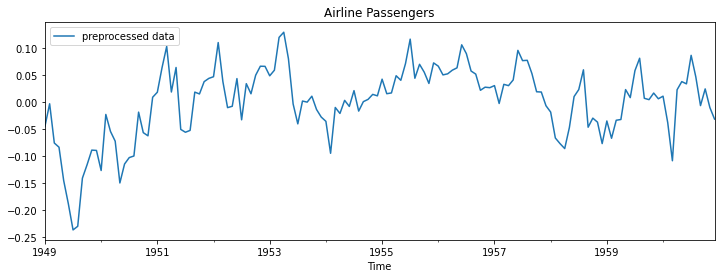

In [21]:
df['preprocessed'] = df['detrended'] - df['seasonality']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [22]:
testdf=df[94:]
df=df[:94].copy()

## 2. Approach 1: Prediction by the global mean

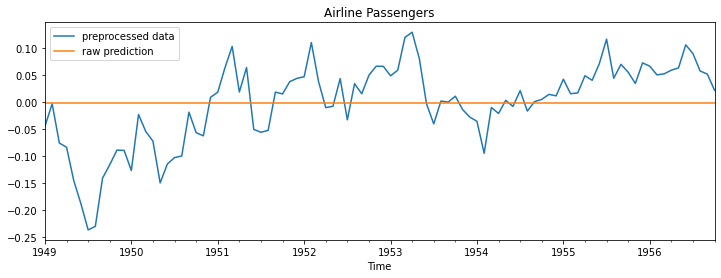

In [23]:
df['prediction_raw'] = df['preprocessed'].mean()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

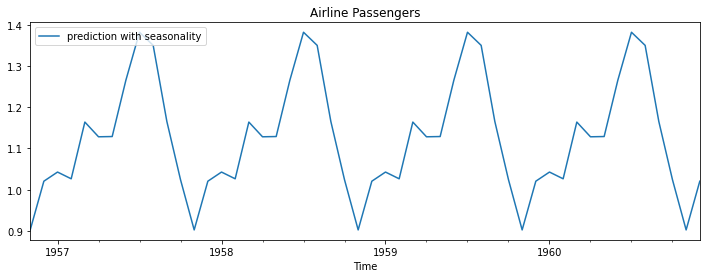

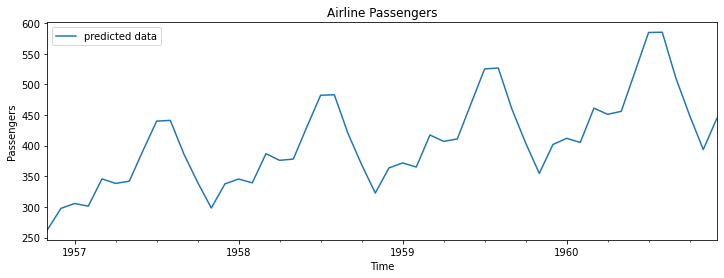

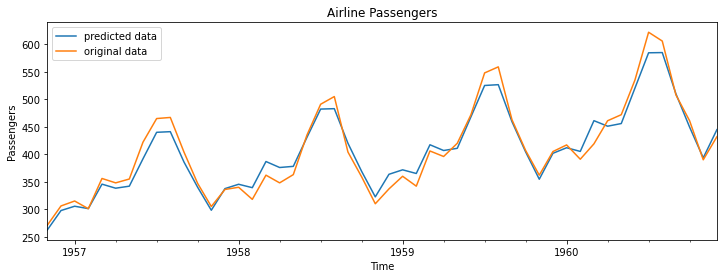

In [31]:
plt.figure(figsize=(12,4))
(df['prediction_raw'][0] + testdf['seasonality']).plot(label='prediction with seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
((df['prediction_raw'][0] + testdf['seasonality']) * testdf['trend']).plot(label='predicted data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

testdf['prediction'] = (df['prediction_raw'][0] + testdf['seasonality']) * testdf['trend']

plt.figure(figsize=(12,4))
testdf['prediction'].plot(label='predicted data')
testdf['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

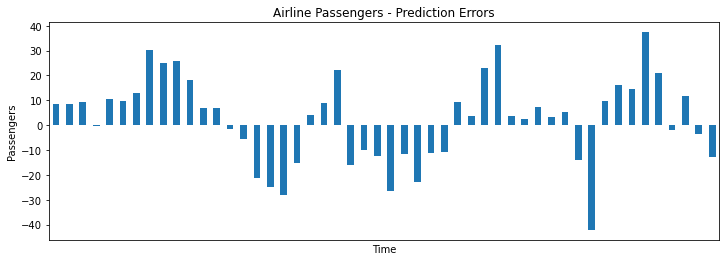

In [32]:
plt.figure(figsize=(12,4))
(testdf['Passengers'] - testdf['prediction']).plot(kind='bar')
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers - Prediction Errors')
plt.show()

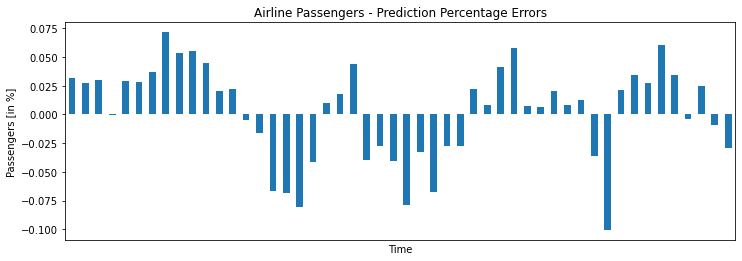

In [33]:
plt.figure(figsize=(12,4))
((testdf['Passengers'] - testdf['prediction']) / testdf['Passengers']).plot(kind='bar')
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Passengers [in %]')
plt.title('Airline Passengers - Prediction Percentage Errors')
plt.show()

In [13]:
print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())

MSE: 199.9625


In [35]:
print('MSE: %0.4f' % ((testdf['Passengers'] - testdf['prediction'])**2).mean())

MSE: 290.7461


In [14]:
print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())

MAE: 11.2917


In [36]:
print('MAE: %0.4f' % (testdf['Passengers'] - testdf['prediction']).abs().mean())

MAE: 14.0196


In [37]:
print('MAPE: %0.4f' % ((testdf['Passengers'] - testdf['prediction']) / testdf['Passengers']).abs().mean())

MAPE: 0.0342


## 3. Approach 2: Prediction by the previous value

In [47]:
len(testdf)

50

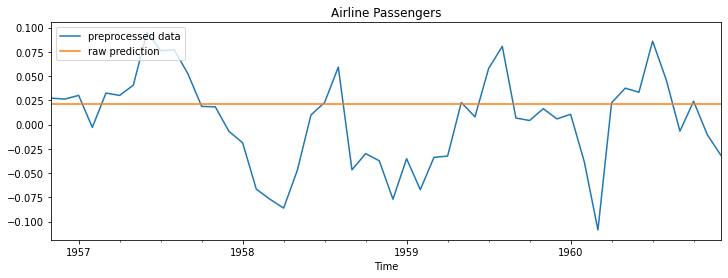

In [49]:
#Ten wypadek przy przewidywaniu upraszcza się do ostatniej znanej wartości
testdf['prediction_raw'] = np.full(len(testdf),df['preprocessed'][-1])

plt.figure(figsize=(12,4))
testdf['preprocessed'].plot(label='preprocessed data')
testdf['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

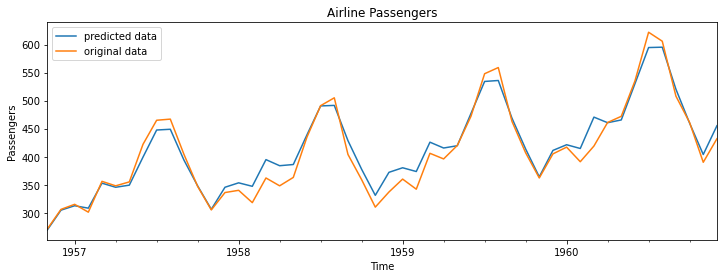

MSE: 325.8175
MAE: 13.7944
MAPE: 0.0349


In [50]:
testdf['prediction'] = (testdf['prediction_raw'] + testdf['seasonality']) * testdf['trend']

plt.figure(figsize=(12,4))
testdf['prediction'].plot(label='predicted data')
testdf['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((testdf['Passengers'] - testdf['prediction'])**2).mean())
print('MAE: %0.4f' % (testdf['Passengers'] - testdf['prediction']).abs().mean())
print('MAPE: %0.4f' % ((testdf['Passengers'] - testdf['prediction']) / testdf['Passengers']).abs().mean())

#Orginalne
#MSE: 113.5205
#MAE: 7.5205
#MAPE: 0.0279

## 4. Approach 3: Prediction by the moving average

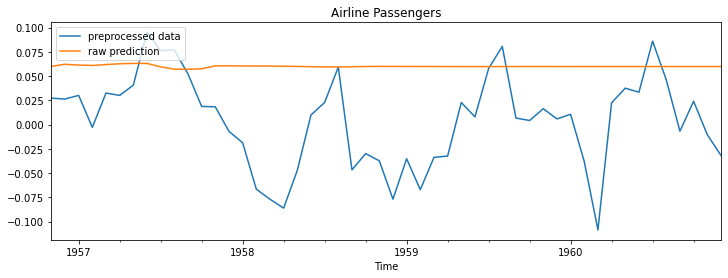

In [54]:
testdf['prediction_raw'] = np.zeros(len(testdf))
L=[]
for i in range(len(testdf)):
    if i<12:
        suma=np.sum(df['preprocessed'][-12+i:])+sum(L[:i])
    else:
        suma=sum(L[i-12:i])
    L.append(suma/12)
testdf['prediction_raw']=np.array(L)
plt.figure(figsize=(12,4))
testdf['preprocessed'].plot(label='preprocessed data')
testdf['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

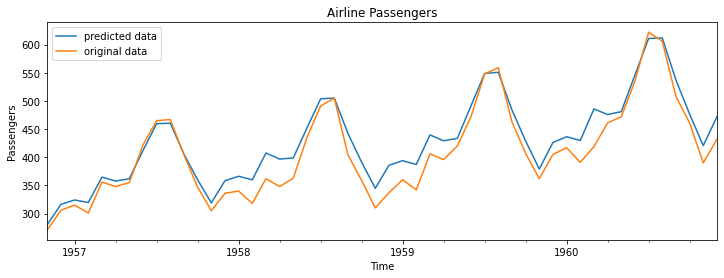

MSE: 698.2832
MAE: 21.7919
MAPE: 0.0573


In [55]:
testdf['prediction'] = (testdf['prediction_raw'] + testdf['seasonality']) * testdf['trend']

plt.figure(figsize=(12,4))
testdf['prediction'].plot(label='predicted data')
testdf['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((testdf['Passengers'] - testdf['prediction'])**2).mean())
print('MAE: %0.4f' % (testdf['Passengers'] - testdf['prediction']).abs().mean())
print('MAPE: %0.4f' % ((testdf['Passengers'] - testdf['prediction']) / testdf['Passengers']).abs().mean())

#Orginalne:
#MSE: 133.8462
#MAE: 8.9120
#MAPE: 0.0335

## 5. Approach 4: Prediction by the linear regression

In [59]:
reg = linear_model.LinearRegression()

X = df['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y = df['preprocessed'].values[1:]

reg.fit(X, y)

Xlast=X[-1,:]
y_predicted=[]
for i in range(len(testdf)):
    y_predicted.append(reg.predict(Xlast.reshape((1,-1))))
    Xlast=y_predicted[-1]
y_predicted=np.array(y_predicted)

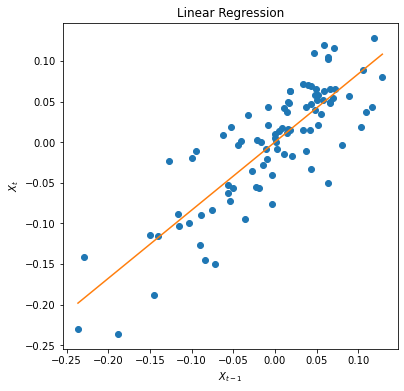

In [60]:
plt.figure(figsize=(6,6))
plt.plot(X[:, 0], y, 'o')
plt.plot([X.min(), X.max()], [reg.coef_[0] * X.min() + reg.intercept_, reg.coef_[0] * X.max() + reg.intercept_], '-')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_t$')
plt.title('Linear Regression')
plt.show()

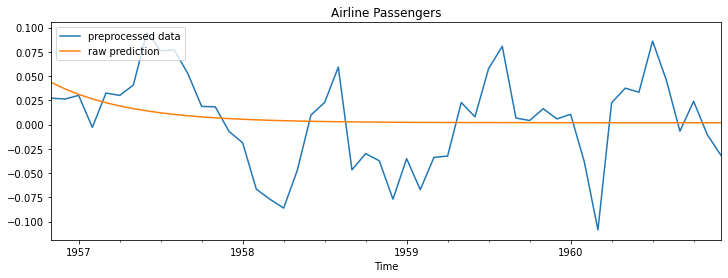

In [62]:
testdf['prediction_raw'] = y_predicted

plt.figure(figsize=(12,4))
testdf['preprocessed'].plot(label='preprocessed data')
testdf['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

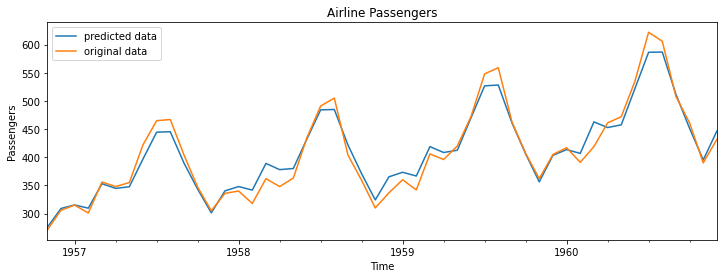

MSE: 272.5810
MAE: 13.0516
MAPE: 0.0319


In [65]:
testdf['prediction'] = (testdf['prediction_raw'] + testdf['seasonality']) * testdf['trend']

plt.figure(figsize=(12,4))
testdf['prediction'].plot(label='predicted data')
testdf['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((testdf['Passengers'] - testdf['prediction'])**2).mean())
print('MAE: %0.4f' % (testdf['Passengers'] - testdf['prediction']).abs().mean())
print('MAPE: %0.4f' % ((testdf['Passengers'] - testdf['prediction']) / testdf['Passengers']).abs().mean())

#Org:
#MSE: 98.3468
#MAE: 7.2347
#MAPE: 0.0273

## 6. Approach 4a: Prediction by the multidimensional linear regression

In [70]:
def make_prediction_with_linear_regression(df, y_predicted):
    df['prediction_raw'] = y_predicted

    plt.figure(figsize=(12,4))
    df['preprocessed'].plot(label='preprocessed data')
    df['prediction_raw'].plot(label='raw prediction')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.title('Airline Passengers')
    plt.legend(loc='upper left')
    plt.show()

    df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

    plt.figure(figsize=(12,4))
    df['prediction'].plot(label='predicted data')
    df['Passengers'].plot(label='original data')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.title('Airline Passengers')
    plt.legend(loc='upper left')
    plt.show()

    print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
    print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
    print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())

### 6.1. Prediction by the linear regression on the two previous values

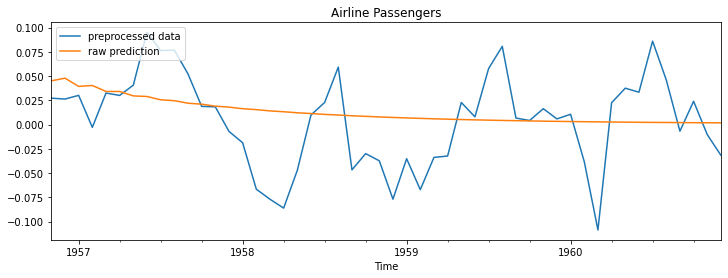

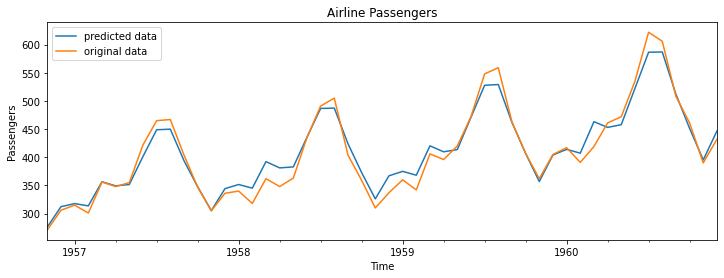

MSE: 281.0503
MAE: 12.9995
MAPE: 0.0322


In [71]:
reg = linear_model.LinearRegression()

X = np.vstack([
    df['preprocessed'].shift(1).values[2:],
    df['preprocessed'].shift(2).values[2:]
]).T
y = df['preprocessed'].values[2:]

reg.fit(X, y)

Xlast=np.array(X[-1,:])
y_predicted=[]
for i in range(len(testdf)):
    y_predicted.append(reg.predict(Xlast.reshape((1,-1))))
    Xlast[:-1]=Xlast[1:]
    Xlast[-1]=y_predicted[-1]
y_predicted=np.array(y_predicted)

make_prediction_with_linear_regression(testdf, y_predicted)

### 6.2. Prediction by the linear regression on the three previous values

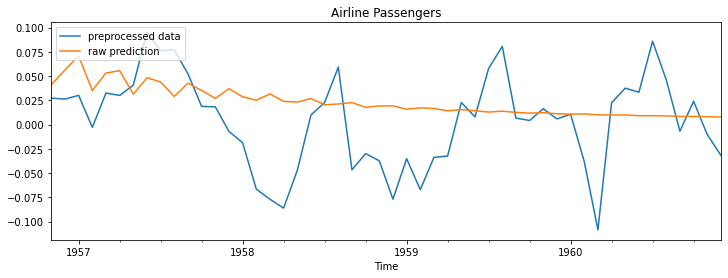

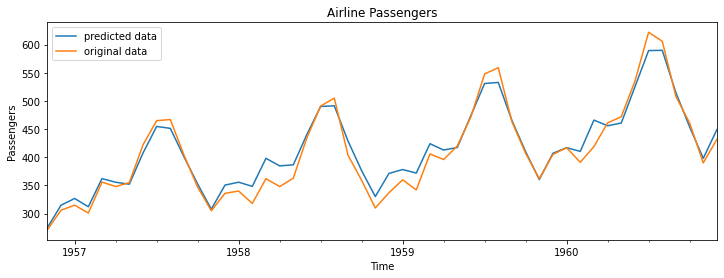

MSE: 316.9108
MAE: 13.9770
MAPE: 0.0356


In [72]:
reg = linear_model.LinearRegression()

X = np.vstack([
    df['preprocessed'].shift(1).values[3:],
    df['preprocessed'].shift(2).values[3:],
    df['preprocessed'].shift(3).values[3:]
]).T
y = df['preprocessed'].values[3:]

reg.fit(X, y)

Xlast=np.array(X[-1,:])
y_predicted=[]
for i in range(len(testdf)):
    y_predicted.append(reg.predict(Xlast.reshape((1,-1))))
    Xlast[:-1]=Xlast[1:]
    Xlast[-1]=y_predicted[-1]
y_predicted=np.array(y_predicted)

make_prediction_with_linear_regression(testdf, y_predicted)
#MSE: 98.3049
#MAE: 7.1479
#MAPE: 0.0268

### 6.3. Autocorrelation

In [27]:
np.corrcoef(df['preprocessed'][1:], df['preprocessed'].shift(1)[1:])

array([[1.        , 0.80477507],
       [0.80477507, 1.        ]])

In [28]:
np.corrcoef(df['preprocessed'][2:], df['preprocessed'].shift(2)[2:])

array([[1.        , 0.68492405],
       [0.68492405, 1.        ]])

In [29]:
np.corrcoef(df['preprocessed'][3:], df['preprocessed'].shift(3)[3:])

array([[1.        , 0.55053101],
       [0.55053101, 1.        ]])

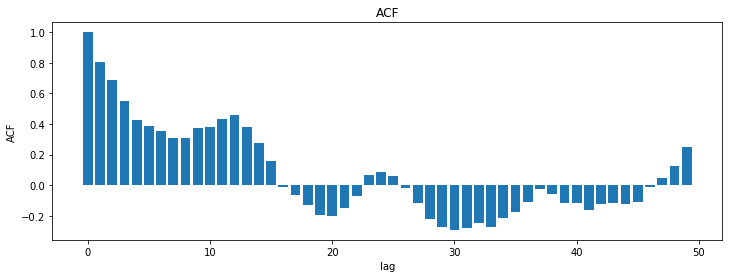

In [30]:
acf = np.zeros(50)
for lag in range(len(acf)):
    acf[lag] = np.corrcoef(df['preprocessed'][lag:], df['preprocessed'].shift(lag)[lag:])[0, 1]

plt.figure(figsize=(12,4))
plt.bar(range(len(acf)), acf)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF')
plt.show()

### 6.4. Prediction by the linear regression on the 15 previous values

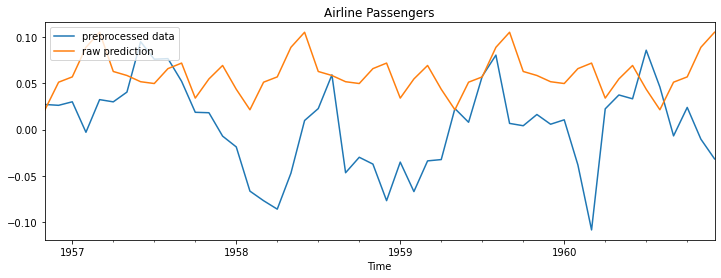

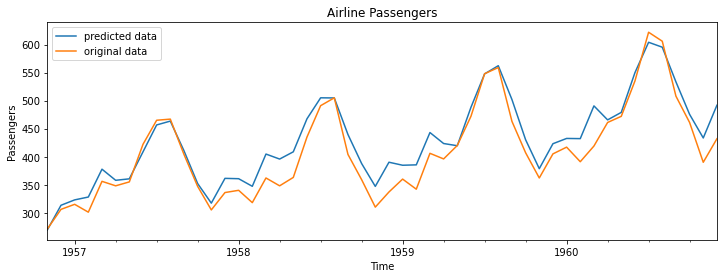

MSE: 784.4666
MAE: 22.3727
MAPE: 0.0582


In [75]:
reg = linear_model.LinearRegression()

X = np.vstack([df['preprocessed'].shift(lag).values[15:] for lag in range(15)]).T
y = df['preprocessed'].values[15:]

reg.fit(X, y)

Xlast=np.array(X[-1,:])
y_predicted=[]
for i in range(len(testdf)):
    y_predicted.append(reg.predict(Xlast.reshape((1,-1))))
    Xlast[:-1]=Xlast[1:]
    Xlast[-1]=y_predicted[-1]
y_predicted=np.array(y_predicted)

make_prediction_with_linear_regression(testdf, y_predicted)
#MSE: 28.3243
#MAE: 1.4533
#MAPE: 0.0112

## 7. Remarks

- split the dataset into the train and the test part and repeat the experiments with learning the model on the train dataset and testing on the test dataset for a more reliable validation
- repeat the experiments without removing the trend and/or the seasonality
- repeat the experiments with the subtracting the trend from the original data instead of dividing them by the trend
- similarly, concerning the seasonality
- try to evaluate the trend with other methods, especially simple moving averages vs. exponential moving averages
- study the variance/standard deviation of the data in time, try to normalize it

# b

In [84]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])

In [85]:
reg = linear_model.LinearRegression()

X = df['Passengers'].shift(1).values[1:].reshape(-1, 1)
y = df['Passengers'].values[1:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[1:] = reg.predict(X)

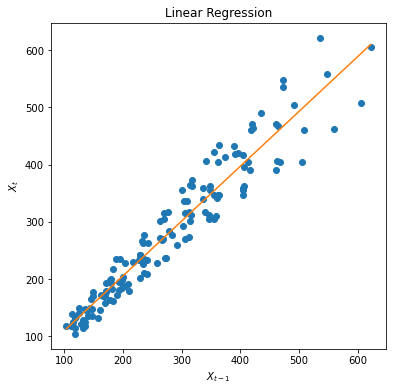

In [86]:
plt.figure(figsize=(6,6))
plt.plot(X[:, 0], y, 'o')
plt.plot([X.min(), X.max()], [reg.coef_[0] * X.min() + reg.intercept_, reg.coef_[0] * X.max() + reg.intercept_], '-')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_t$')
plt.title('Linear Regression')
plt.show()

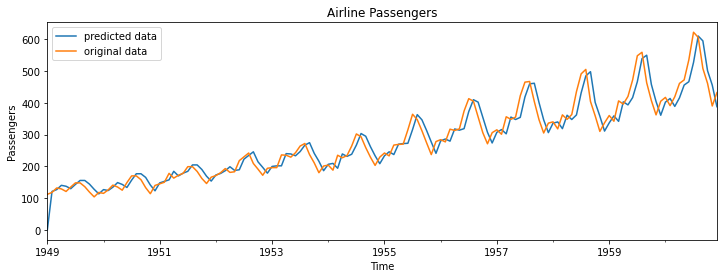

MSE: 1186.8051
MAE: 26.2277
MAPE: 0.0967


In [87]:
df['prediction'] = y_predicted

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())

# e

In [124]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])

df['trend'] = df['Passengers'].ewm(halflife=12).mean()
df['detrended'] = df['Passengers'] / df['trend']
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
df = df.join(df_seasonality, how='left', on=df.index.month)
df['preprocessed0'] = df['detrended'] - df['seasonality']
df["preprocessed"]=df["preprocessed0"]-df['preprocessed0'].shift(1).fillna(0.0)

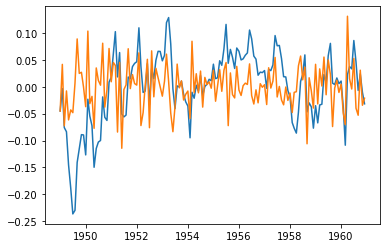

In [128]:
plt.plot(df["preprocessed0"])
plt.plot(df["preprocessed"])

In [129]:
df['wariancjaKrocz2'] = df['preprocessed'].rolling(window=12, min_periods=1).var()
df['wariancjaKrocz'] = df['preprocessed0'].rolling(window=12, min_periods=1).var()

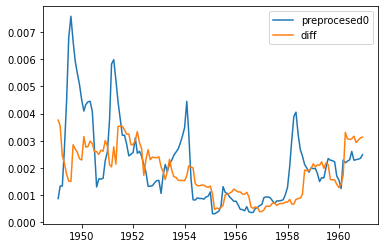

In [130]:
plt.plot(df["wariancjaKrocz"], label="preprocesed0")
plt.plot(df["wariancjaKrocz2"], label="diff")
plt.legend()

In [134]:
reg = linear_model.LinearRegression()

X = df['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y = df['preprocessed'].values[1:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[1:] = reg.predict(X)

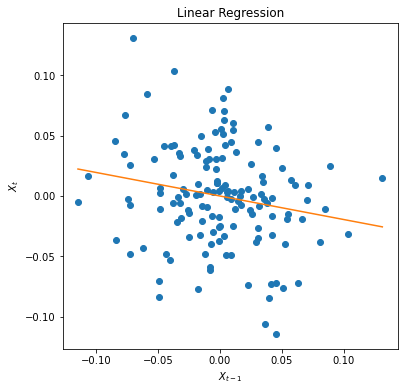

In [135]:
plt.figure(figsize=(6,6))
plt.plot(X[:, 0], y, 'o')
plt.plot([X.min(), X.max()], [reg.coef_[0] * X.min() + reg.intercept_, reg.coef_[0] * X.max() + reg.intercept_], '-')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_t$')
plt.title('Linear Regression')
plt.show()

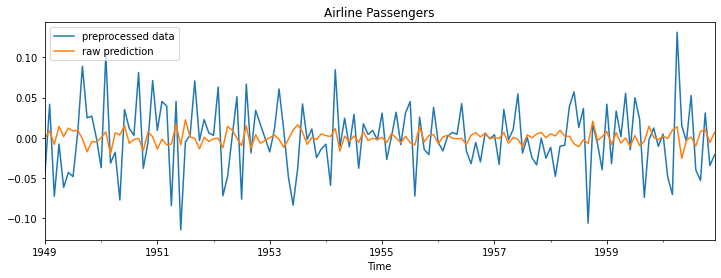

In [137]:
df['prediction_raw'] = y_predicted

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

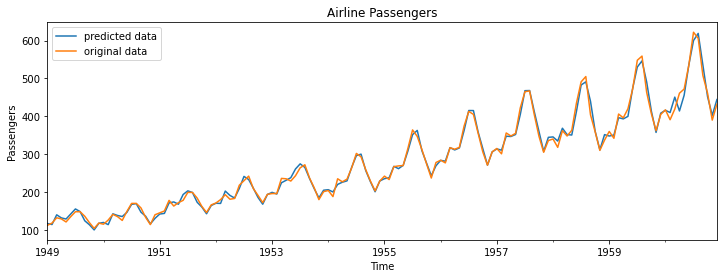

MSE: 109.1555
MAE: 7.4677
MAPE: 0.0278


In [142]:
df['prediction'] = (df['prediction_raw'] +df['preprocessed0'].shift(1).fillna(0.0) + df['seasonality']) * df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())